# Stroke predictions and analysis

**Table of Contents:**

1. [Load Data and Analyse](#load)
2. [EDA](#EDA)
3. [Data Preparation and Preprocessing](#data-preprocessing)
4. [Model exploration](#model-exploration) 
5. [Oversampling our minority features](#oversampling-data)
6. [Test set predictions](#test-predictions)

In [1]:
!pip install pydotplus

     |████████████████████████████████| 278 kB 1.3 MB/s 
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=54e572dec328a8f49a6af616c777c66d34208e5774b2a0c7fb91ac408b19d7a2
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


In [2]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor, cv, Pool
from collections import defaultdict

from imblearn.over_sampling import SMOTE
from IPython.display import Image
from pydotplus import graph_from_dot_data
        
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_curve, \
                            recall_score, confusion_matrix, classification_report, \
                            auc, precision_recall_curve
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

<a id="load"></a>
## 1. Load Data and inspect top level features

In [3]:
data_dir = '/kaggle/input/stroke-prediction-dataset'
data_df = pd.read_csv(os.path.join(data_dir, 'healthcare-dataset-stroke-data.csv'))
data_df.shape

(5110, 12)

In [4]:
data_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
data_df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

Check for missing values within our data:

In [7]:
data_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

It appears our BMI column is missing a fair number of values within the dataset. We'll have to implement some means of either imputing approximate values, or dealing with the missing values in some way.

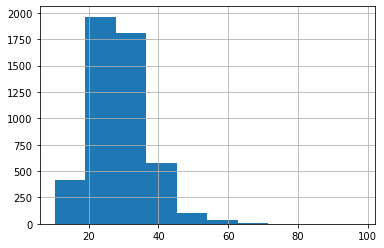

In [8]:
data_df['bmi'].hist()
plt.show()

In [9]:
data_df[data_df.isnull().any(axis=1)]['stroke'].value_counts()

0    161
1     40
Name: stroke, dtype: int64

Its probably reasonable to simply impute all missing BMI values as the median. Conversely, if we wanted something more sophisticated than this we could create a model to predict the BMI missing values using regression.

In [10]:
data_df['bmi'] = data_df['bmi'].fillna(data_df['bmi'].median())

In [11]:
data_df.isna().sum().sum()

0

Good, we've dealt with all missing values within our dataset. Now lets proceed onwards to some exploratory data analysis.

<a id="EDA"></a>
## 2. Exploratory Data Analysis (EDA)

### 2.1 Analysis of Categorical Features

In [12]:
def custom_countplot(data_df, col_name, ax=None):
    """ Plot seaborn countplot for selected dataframe col """
    c_plot = sns.countplot(x=col_name, data=data_df, ax=ax)
    for g in c_plot.patches:
        c_plot.annotate(f"{g.get_height()}",
                        (g.get_x()+g.get_width()/3,
                         g.get_height()+60))

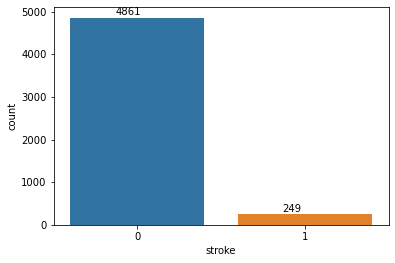

In [13]:
custom_countplot(data_df=data_df, col_name='stroke')

Lets do similar plots for all of our categorical columns:

In [14]:
data_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [15]:
cat_cols = data_df.loc[:, data_df.dtypes == object].columns.values
cat_cols

array(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'], dtype=object)

Note that all our categorical variables have not been identified above - we have additional ones that are already encoded as numerical features, such as hypertension and heart_disease. We'll add these to our list so we've got them all...

In [16]:
cat_cols = np.append(cat_cols, ['hypertension', 'heart_disease', 'stroke'])

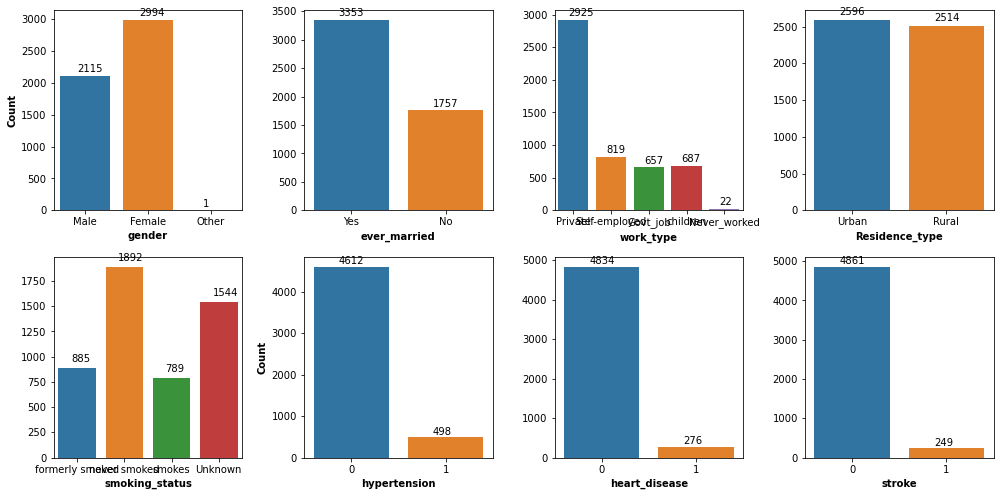

In [17]:
n = len(cat_cols)

fig, axs = plt.subplots(2, 4, figsize=(14,7))
axs = axs.flatten()

# iterate through each col and plot
for i, col_name in enumerate(cat_cols):
    custom_countplot(data_df, col_name, ax=axs[i])
    axs[i].set_xlabel(f"{col_name}", weight = 'bold')
    axs[i].set_ylabel('Count', weight='bold')
    
    if (i != 0 and i != 5):
        axs[i].set_ylabel('')
        
plt.tight_layout()
plt.show()

We have a fairly good balance of categorical feature values across our data, with exception to one or two minorities. For example, we have a very low number of cases of hypertension (1) and heart_disease (1). In addition, our target variable (stroke) seems to be extremely imbalanced. As such, we should consider applying some techniques to help work with imbalanced data, otherwise we will have poor generlisation in our models.

In [18]:
data_df['stroke'].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

As shown, we have less than 5% data that is for those that had a stroke. For instances like this, we need to be careful on the training and evaluation of models, due to the severe data imbalance that we have.

Lets convert our hypertension and heart_disease variables into objects so that our data preprocessor handles them accordingly later.

In [19]:
cat_map_dict = { x : 'object' for x in ['hypertension', 'heart_disease'] }
data_df = data_df.astype(cat_map_dict)

This seems pointless (and it kind of is), since I have done this purely for convenience, so that we identify our categorical columns as those that are object dtypes later during preprocessing.

### 2.2 Analysis of Numerical Features

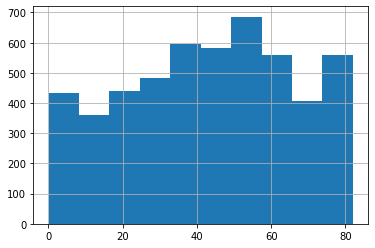

In [20]:
data_df['age'].hist()
plt.show()

In [21]:
num_variables = ['age', 'avg_glucose_level', 'bmi']

In [22]:
def target_boxplot(y_val_col, x_val_col, data_df, figsize=(9,6), ax=None, name="Boxplot"):
    """ Custom boxplot function - plot a chosen value against target x col """
    
    fig, ax = plt.subplots(figsize=figsize)
    b_plot = sns.boxplot(x=x_val_col, y=y_val_col, data=data_df, ax=ax)
    
    medians = data_df.groupby(x_val_col)[y_val_col].median()
    vert_offset = data_df[y_val_col].median() * 0.05 
    
    for xtick in b_plot.get_xticks():
        b_plot.text(xtick, medians[xtick] + vert_offset, medians[xtick], 
                horizontalalignment='center',size='small',color='w',weight='semibold')
        
    plt.title(f"{name}", weight='bold')
    plt.show()

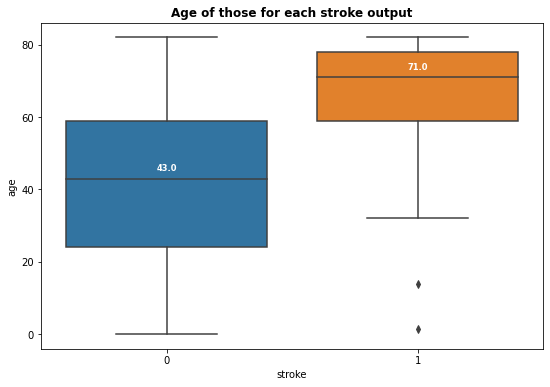

In [23]:
target_boxplot('age', 'stroke', data_df, 
               name='Age of those for each stroke output')

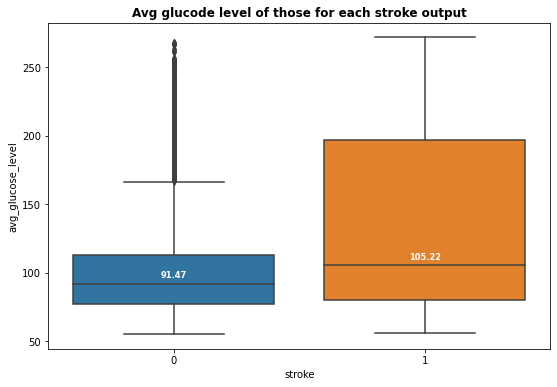

In [24]:
target_boxplot('avg_glucose_level', 'stroke', data_df, 
               name='Avg glucode level of those for each stroke output')

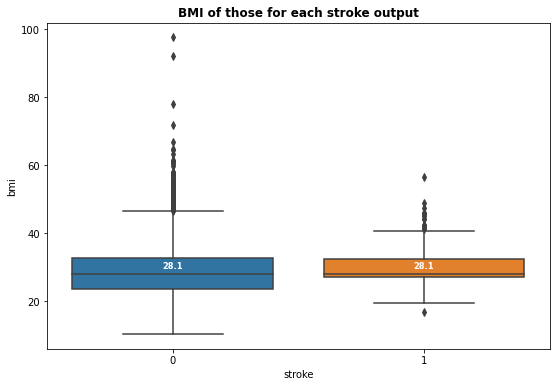

In [25]:
target_boxplot('bmi', 'stroke', data_df, 
               name='BMI of those for each stroke output')

Lets look at the relationship and correlation of numerical variables against our target stroke variable:

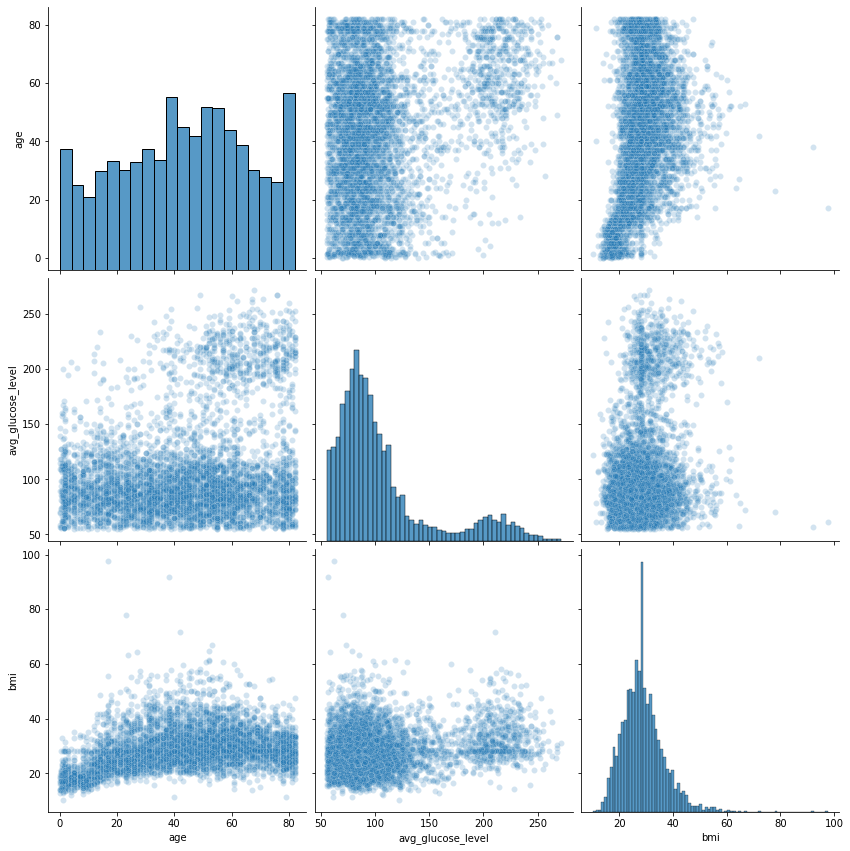

In [26]:
plot_cols = ['age', 'avg_glucose_level', 'bmi']
sns.pairplot(data_df.loc[:, plot_cols], height=4, plot_kws={'alpha':0.2})
plt.show()

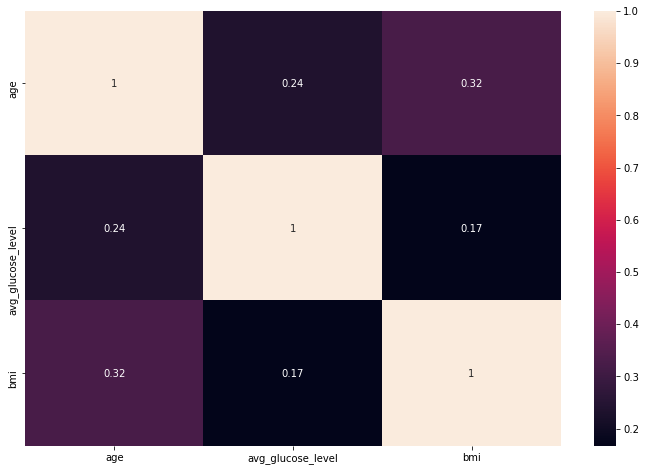

In [27]:
# find the correlation between our variables
corr = data_df.loc[:, plot_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True)
plt.show()

We have a few fairly strong correlations between our variables, however they do not resemble anywhere near perfect correlation (1.0), and so we should generally keep all of our variables in this case. If we had a huge number of features, with many being very highly correlated, it could be worth eliminating some to reduce redundancy. In this case we have nothing to worry about, since we have a few low number of variables in the dataset.

<a id="data-preprocessing"></a>
## 3. Data Preprocessing

Its important that we handle our numerical and categorical features appropriately prior to producing our models.

We'll put together some preprocessing functions to encode our categorical features and standardise our numerical features. Whilst doing this, we'll also add support for producing additional dimensionality-reduced features (using PCA) to our dataset.

These extra features will allow us to experiment and tune to find the best combinations of feature engineering to perform for this problem.

In [28]:
class DataProcessor(object):
    def __init__(self):
        self.encoder = None
        self.standard_scaler = None
        self.num_cols = None
        self.cat_cols = None
        
    def preprocess(self, data_df, train=True, one_hot_encode=False,
                   add_pca_feats=False):
        """ Preprocess train / test as required """
        
        # if training, fit our transformers
        if train:
            self.train_ids = data_df.loc[:, 'id']
            train_cats = data_df.loc[:, data_df.dtypes == object]
            self.cat_cols = train_cats.columns
            
            # if selected, one hot encode our cat features
            if one_hot_encode:
                self.encoder = OneHotEncoder(handle_unknown='ignore')
                oh_enc = self.encoder.fit_transform(train_cats).toarray()
                train_cats_enc = pd.DataFrame(oh_enc, columns=self.encoder.get_feature_names())
                self.final_cat_cols = list(train_cats_enc.columns)
            
            # otherwise just encode our cat feats with ints
            else:
                # encode all of our categorical variables
                self.encoder = defaultdict(LabelEncoder)
                train_cats_enc = train_cats.apply(lambda x: 
                                                  self.encoder[x.name].fit_transform(x))
                self.final_cat_cols = list(self.cat_cols)
            
            
            # standardise all numerical columns
            train_num = data_df.loc[:, data_df.dtypes != object].drop(columns=['stroke', 'id'])
            self.num_cols = train_num.columns
            self.standard_scaler = StandardScaler()
            train_num_std = self.standard_scaler.fit_transform(train_num)
            
            # add pca reduced num feats if selected, else just combine num + cat feats
            if add_pca_feats:
                pca_feats = self._return_num_pca(train_num_std)
                self.final_num_feats = list(self.num_cols)+list(self.pca_cols)
                
                
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            else:   
                self.final_num_feats = list(self.num_cols)
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols))
        
        # otherwise, treat as test data
        else:
            # transform categorical and numerical data
            self.test_ids = data_df.loc[:, 'id']
            cat_data = data_df.loc[:, self.cat_cols]
        
            if one_hot_encode:
                oh_enc = self.encoder.transform(cat_data).toarray()
                cats_enc = pd.DataFrame(oh_enc, columns=self.encoder.get_feature_names())
            else:
                cats_enc = cat_data.apply(lambda x: self.encoder[x.name].transform(x))
                
            # transform test numerical data
            num_data = data_df.loc[:, self.num_cols]
            num_std = self.standard_scaler.transform(num_data)
            
            if add_pca_feats:
                pca_feats = self._return_num_pca(num_std, train=False)
                
                X = pd.DataFrame(np.hstack((cats_enc, num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            
            else:
                X = pd.DataFrame(np.hstack((cats_enc, num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)) 
        return X
    
    def _return_num_pca(self, num_df, n_components=0.85, train=True):
        """ return dim reduced numerical features using PCA """
        if train:
            self.pca = PCA(n_components=n_components)
            num_rd = self.pca.fit_transform(num_df)
            
            # create new col names for our reduced features
            self.pca_cols = [f"pca_{x}" for x in range(num_rd.shape[1])]
            
        else:
            num_rd = self.pca.transform(num_df)
        
        return pd.DataFrame(num_rd, columns=self.pca_cols)

Lets transform our data into a form suitable for training various models. This includes encoding our categorical variables, and standardising our numerical variables.

We can either encode our categorical feature values, or one-hot encode them. Our preprocessing function supports whichever we want, through simply setting the one_hot_encode argument as true (one-hot encoding) or false (simple numerical encoding). We obtain a larger number of feature columns if we one-hot encode, and therefore introduce more complexity. However, many models perform better with one-hot encoding, so it is worth trying both techniques for our range of models.

We'll be using mainly tree-based methods in this notebook, and as such one-hot encoding and simple encoding of features does not actually make any noticeable difference (as demonstrated through years of empirical research and comparisons). Therefore, we'll keep our dataset simpler and just use categorical encoding.

In [29]:
data_proc = DataProcessor()

# simply preprocess without one-hot encoding or pca feats
#X = data_proc.preprocess(data_df)

# advanced preprocessing- include pca feats + one hot encoding
X = data_proc.preprocess(data_df, one_hot_encode=True, add_pca_feats=True)
y = data_df.loc[:, 'stroke']

print(f"X: {X.shape} \ny: {y.shape}")

X: (5110, 26) 
y: (5110,)


In [30]:
X

,x0_Female,x0_Male,x0_Other,x1_0,x1_1,x2_0,x2_1,x3_No,x3_Yes,x4_Govt_job,...,x6_Unknown,x6_formerly smoked,x6_never smoked,x6_smokes,age,avg_glucose_level,bmi,pca_0,pca_1,pca_2
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.051434,2.706375,1.005086,2.622405,-1.537637,0.445922
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.786070,2.121559,-0.098981,1.510329,-1.679292,-0.166135
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.626390,-0.005028,0.472536,1.302923,0.537628,-0.939046
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.255342,1.437358,0.719327,1.310296,-0.771913,0.579574
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.582163,1.501184,-0.631531,1.386951,-1.304598,-1.236939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.626390,-0.494658,-0.098981,0.719641,0.643787,-1.402599
5106,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.670617,0.420775,1.446713,2.118583,0.704431,-0.276356
5107,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.363842,-0.511443,0.225745,-0.355599,0.480689,0.295638
5108,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.343796,1.328257,-0.423706,0.639221,-1.267891,-0.214100


In [31]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)
print(f"X_train_full: {X_train_full.shape} \ny_train_full: {y_train_full.shape} \nX_val: {X_test.shape}, \ny_val: {y_test.shape}")

X_train_full: (4088, 26) 
y_train_full: (4088,) 
X_val: (1022, 26), 
y_val: (1022,)


In [32]:
y_train_full.value_counts(normalize=True)

0    0.951321
1    0.048679
Name: stroke, dtype: float64

In [33]:
y_test.value_counts(normalize=True)

0    0.951076
1    0.048924
Name: stroke, dtype: float64

As shown above, we need to ensure we stratify our split on y, since we have such an imbalanced dataset.

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=12, stratify=y_train_full)
print(f"X_train: {X_train.shape} \ny_train_full: {y_train.shape} \nX_val: {X_val.shape}, \ny_val: {y_val.shape}")

X_train: (3270, 26) 
y_train_full: (3270,) 
X_val: (818, 26), 
y_val: (818,)


<a id="model-exploration"></a>
## 4. Exploring our dataset with the use of different models

In [35]:
def show_tree_graph(tree_model, feature_names):
    """ Output a decision tree to notebook """
    draw_data = export_graphviz(tree_model, filled=True, 
                                rounded=True, feature_names=feature_names, 
                                out_file=None, rotate=True, class_names=True)
    graph = graph_from_dot_data(draw_data)

    return Image(graph.create_png())

In [36]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=3)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3)

A random forest uses a large number of individual decision trees, and averages these to create an overall model that is more robust and better performing. We can inspect the underlying decision trees within our random forest model using the estimators_ array, like so:

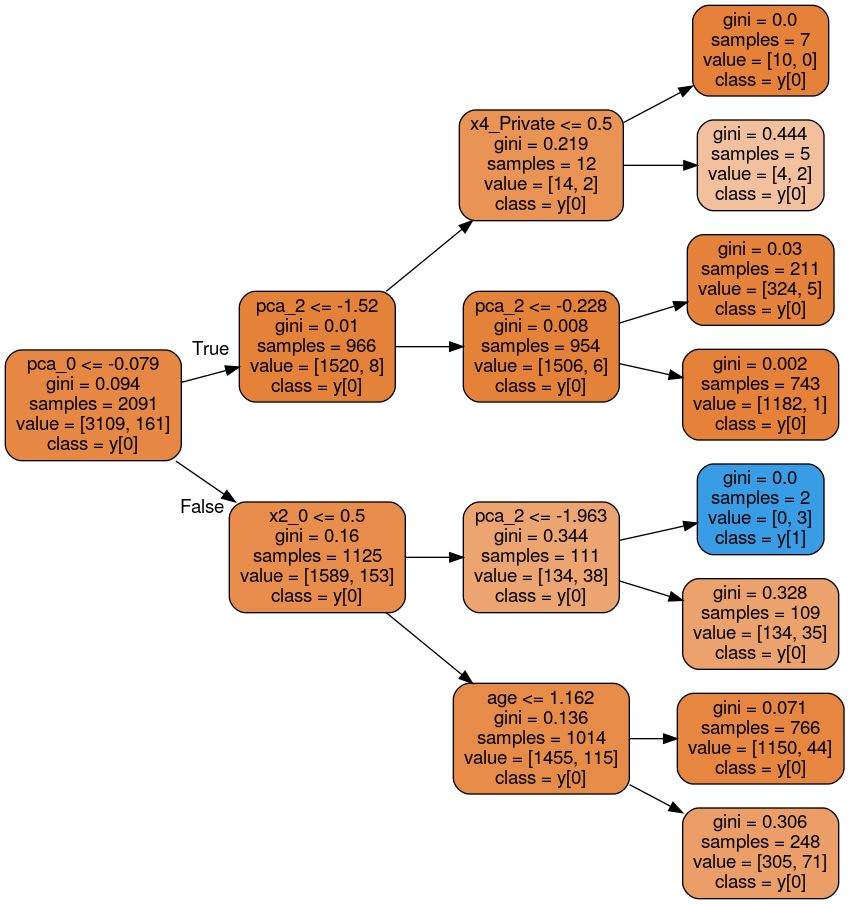

In [37]:
show_tree_graph(rf_clf.estimators_[0], list(X_train.columns))

A key feature of Random Forest models is the ability to ability to compute feature importances. We can grade this feature importance in multiple ways. The popular way (used by Scikit-Learn) is to measure how much a feature reduces the impurity on average across all trees in the forest. For our model, this would equate to measuring on average how strongly each feature reduces the cost function across all our tree models.

In [38]:
def feature_importances(rf_model, dataframe):
    """ Return dataframe of feat importances from random forest model """
    return pd.DataFrame({'columns' : dataframe.columns, 
                         'importance' : rf_model.feature_importances_}
                       ).sort_values('importance', ascending=False)

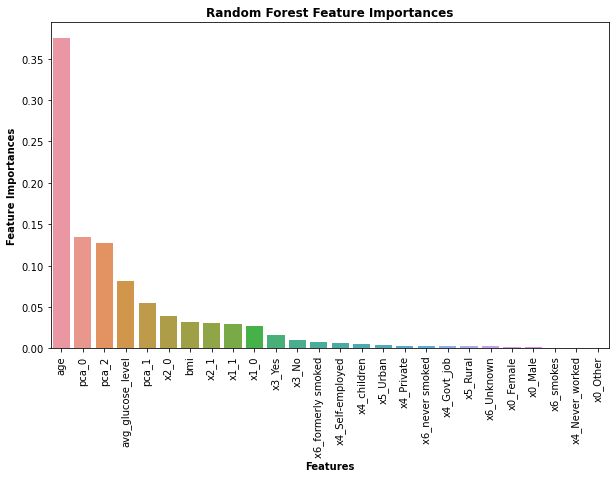

               columns  importance
20                 age    0.375237
23               pca_0    0.134183
25               pca_2    0.127202
21   avg_glucose_level    0.081391
24               pca_1    0.055408
5                 x2_0    0.039372
22                 bmi    0.031900
6                 x2_1    0.031102
4                 x1_1    0.028954
3                 x1_0    0.027501
8               x3_Yes    0.015640
7                x3_No    0.010064
17  x6_formerly smoked    0.008224
12    x4_Self-employed    0.007106
13         x4_children    0.004953
15            x5_Urban    0.003616
11          x4_Private    0.003038
18     x6_never smoked    0.002801
9          x4_Govt_job    0.002712
14            x5_Rural    0.002603
16          x6_Unknown    0.002553
0            x0_Female    0.001720
1              x0_Male    0.001675
19           x6_smokes    0.001046
10     x4_Never_worked    0.000000
2             x0_Other    0.000000


In [39]:
importances = feature_importances(rf_clf, X_train)

plt.figure(figsize=(10,6))
sns.barplot(x="columns", y="importance", data=importances)
plt.ylabel("Feature Importances", weight='bold')
plt.xlabel("Features", weight='bold')
plt.title("Random Forest Feature Importances", weight='bold')
plt.xticks(rotation=90)
plt.show()
print(importances)

In [40]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
val_preds = rf_clf.predict(X_val)
val_acc = accuracy_score(val_preds, y_val)

In [42]:
print(f"Random Forest accuracy on validation set: {val_acc}")

Random Forest accuracy on validation set: 0.9498777506112469


In [43]:
print(classification_report(val_preds, y_val))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       817
           1       0.00      0.00      0.00         1

    accuracy                           0.95       818
   macro avg       0.50      0.48      0.49       818
weighted avg       1.00      0.95      0.97       818



These metrics are hard to appreciate from the values alone, however they do highlight a severe limitation of our model. Lets plot a confusion matrix, which will help illustrate what this is.

In [44]:
def plot_confusion_matrix(true_y, pred_y, title='Confusion Matrix', figsize=(8,6)):
    """ Custom function for plotting a confusion matrix for predicted results """
    conf_matrix = confusion_matrix(true_y, pred_y)
    conf_df = pd.DataFrame(conf_matrix, columns=np.unique(true_y), index = np.unique(true_y))
    conf_df.index.name = 'Actual'
    conf_df.columns.name = 'Predicted'
    plt.figure(figsize = figsize)
    plt.title(title)
    sns.set(font_scale=1.4)
    sns.heatmap(conf_df, cmap="Blues", annot=True, 
                annot_kws={"size": 16}, fmt='g')
    plt.show()
    return

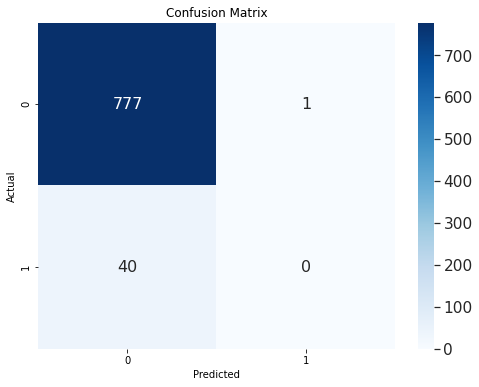

In [45]:
plot_confusion_matrix(y_val, val_preds)

Oh dear, our model doesnt even predict one instance correct for when our data corresponds to a stroke. This highlights the severe data imbalance problem highlighted during our exploratory data analysis earlier.

This is why accuracy is such a poor metric for imbalanced classification problems such as this one - we score 95% accuracy by simply predicting 0 everytime. Since we've made this so easy for our model with such imbalanced data, you cant blame it for taking the easy option and simply predicting 0 all the time.

To overcome this we should always make use of better metrics for such problems, such as precision, recall, f1 score, and various other available metrics.

In [46]:
def multi_model_cross_validation(clf_tuple_list, X, y, K_folds=10, score_type='accuracy', random_seed=0):
    """ Find cross validation scores, and print and return results """
    
    model_names, model_scores = [], []
    
    for name, model in clf_list:
        k_fold = StratifiedKFold(n_splits=K_folds, shuffle=True, random_state=random_seed)
        cross_val_results = cross_val_score(model, X, y, cv=k_fold, scoring=score_type, n_jobs=-1)
        model_names.append(name)
        model_scores.append(cross_val_results)
        print("{0:<40} {1:.5f} +/- {2:.5f}".format(name, cross_val_results.mean(), cross_val_results.std()))
    
    results_dict = { x : y for x in model_names for y in model_scores } 
    
    return pd.melt(pd.DataFrame(results_dict), var_name='model', value_name='results')


def boxplot_comparison(melted_df, figsize=(12, 6), score_type="Accuracy",
                       title="Boxplot Model Results"):
    """ Boxplot comparison of a range of models using Seaborn and matplotlib """
    
    model_names = list(melted_df['model'].unique())
    
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=18)
    ax = fig.add_subplot(111)
    sns.boxplot(x='model', y='results', data=melted_df)
    ax.set_xticklabels(model_names)
    ax.set_xlabel("Model", fontsize=16) 
    ax.set_ylabel("Model Score ({})".format(score_type), fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    plt.show()
    return

In [47]:
# list of classifiers to compare - use some additional models this time
clf_list = [("Perceptron", Perceptron(eta0=0.1)),
            ("Logistic Regression", LogisticRegression(C=10.0, max_iter=200)),
            ("Support Vector Machine", SVC(kernel='linear', C=1.0)),
            ("Decision Tree", DecisionTreeClassifier()),
            ("Random Forest", RandomForestClassifier(n_estimators=300)),
            ("Ridge Classifier", RidgeClassifier()),
            ("Naive Bayes Classifier", GaussianNB()),
            ("Gradient Boosting", GradientBoostingClassifier())]

# calculate cross-validation scores and print / plot for each model accordingly
results_df = multi_model_cross_validation(clf_list, X_train_full, y_train_full, score_type='f1')

Perceptron                               0.12953 +/- 0.13268
Logistic Regression                      0.00952 +/- 0.02857
Support Vector Machine                   0.00000 +/- 0.00000
Decision Tree                            0.10754 +/- 0.06873
Random Forest                            0.00000 +/- 0.00000
Ridge Classifier                         0.00000 +/- 0.00000
Naive Bayes Classifier                   0.12610 +/- 0.00649
Gradient Boosting                        0.02380 +/- 0.03647


Terrible f1 scores, as expected! Lets try and improve this through some application of imbalanced data techniques.

<a id="oversampling-data"></a>
## 5. Oversampling of minority features using SMOTE

In [48]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

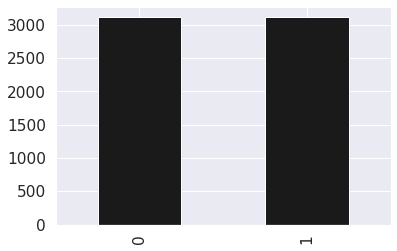

In [49]:
y_train_os.value_counts().plot.bar(color="k")
plt.show()

Good, we've now got a balanced number of samples. Lets see how our models now perform, in comparison to previously.

In [50]:
# calculate cross-validation scores and print / plot for each model accordingly
results_df = multi_model_cross_validation(clf_list, X_train_os, y_train_os, score_type='f1')

Perceptron                               0.74929 +/- 0.07639
Logistic Regression                      0.81215 +/- 0.00961
Support Vector Machine                   0.81738 +/- 0.00719
Decision Tree                            0.92735 +/- 0.00955
Random Forest                            0.96947 +/- 0.00712
Ridge Classifier                         0.81615 +/- 0.00847
Naive Bayes Classifier                   0.73951 +/- 0.00449
Gradient Boosting                        0.93945 +/- 0.00970


Much better results.... HOWEVER - through performing k-folds cross validation like we have in this regard we have actually introduced a huge amount of DATA LEAKAGE.

Since we've duplicated a huge number of stroke instances in the dataset, when we form training and validation splits as part of kfolds cross validation we are actually including a large number of duplicates in both training and validation partitions. This means our model can just memorise instances from the training set, and score perfectly on these same instances in the validation set. 

Therefore, the scores obtained above need to be taken with a massive pinch of salt! To get a much better idea of the generalisation performance of our models, we should perform manual kfolds cross validation that oversamples the training splits using SMOTE on each fold. This ensures no data leakage between our training and validation splits whilst evaluating performance.

We can overcome this issue partially through simply training on the oversampled training set, and making predictions on the non-oversampled validation set. If our performance on this is still terrible, it gives us an idea of how effective our models actually are.

Lets try the random forest model again, and evaluate our predictions on the validation split:

In [51]:
rf_clf = RandomForestClassifier(n_estimators=1000)
rf_clf.fit(X_train_os, y_train_os)
val_preds = rf_clf.predict(X_val)
val_acc = accuracy_score(val_preds, y_val)

In [52]:
print(classification_report(val_preds, y_val))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       784
           1       0.05      0.06      0.05        34

    accuracy                           0.91       818
   macro avg       0.50      0.51      0.50       818
weighted avg       0.92      0.91      0.92       818



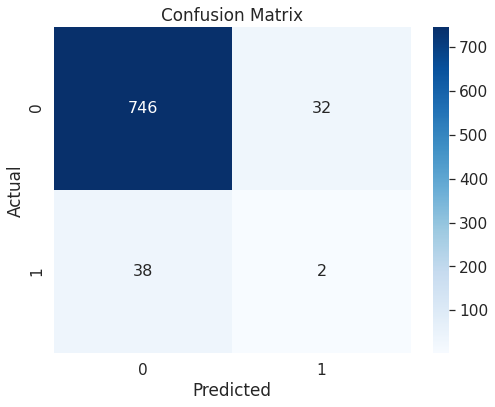

In [53]:
plot_confusion_matrix(y_val, val_preds)

Still not amazing, but definitely a bit better... 

In contrast to the KFolds cross validation scores obtained earlier after SMOTE oversampling, this model performs much worse. Hopefully this highlights how performing incorrect KFolds cross validation with oversampled data can provide over-optimistic estimations on how well our model will perform.

Instead, we should always perform SMOTE within each fold of cross validation, rather than beforehand on the entire training split.

Lets reassess our importances and see if they have changed after over-sampling our data:

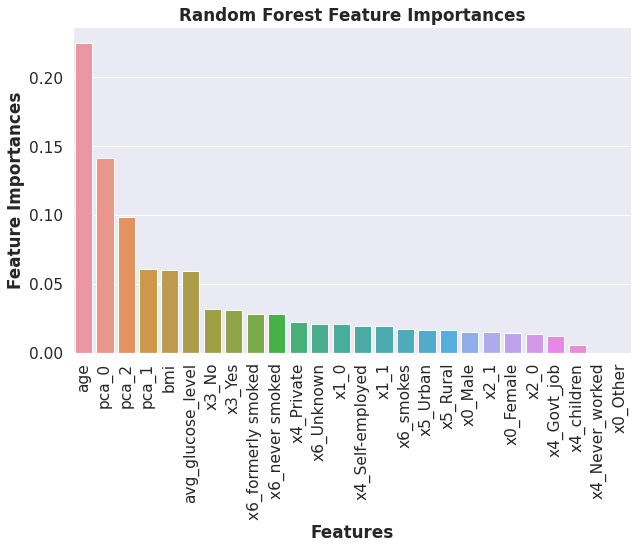

               columns  importance
20                 age    0.225316
23               pca_0    0.141547
25               pca_2    0.099035
24               pca_1    0.061320
22                 bmi    0.060323
21   avg_glucose_level    0.059549
7                x3_No    0.031693
8               x3_Yes    0.031336
17  x6_formerly smoked    0.028718
18     x6_never smoked    0.028084
11          x4_Private    0.022938
16          x6_Unknown    0.021215
3                 x1_0    0.020919
12    x4_Self-employed    0.019736
4                 x1_1    0.019694
19           x6_smokes    0.017789
15            x5_Urban    0.016757
14            x5_Rural    0.016621
1              x0_Male    0.015121
6                 x2_1    0.015016
0            x0_Female    0.014930
5                 x2_0    0.013986
9          x4_Govt_job    0.012356
13         x4_children    0.006000
10     x4_Never_worked    0.000001
2             x0_Other    0.000000


In [54]:
importances = feature_importances(rf_clf, X_train_os)

plt.figure(figsize=(10,6))
sns.barplot(x="columns", y="importance", data=importances)
plt.ylabel("Feature Importances", weight='bold')
plt.xlabel("Features", weight='bold')
plt.title("Random Forest Feature Importances", weight='bold')
plt.xticks(rotation=90)
plt.show()
print(importances)

Age is still by far the most important feature, with BMI closely behind.

In [55]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train_os, y_train_os)
val_preds = gb_clf.predict(X_val)
val_acc = accuracy_score(val_preds, y_val)

In [56]:
print(classification_report(val_preds, y_val))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       737
           1       0.23      0.11      0.15        81

    accuracy                           0.87       818
   macro avg       0.57      0.53      0.54       818
weighted avg       0.84      0.87      0.85       818



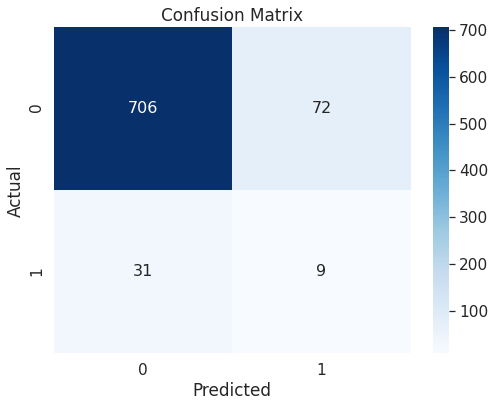

In [57]:
plot_confusion_matrix(y_val, val_preds)

### Analysing the ROC AUC

Much better, and still undoubtedly much more room for improvement through hyper-parameter tuning. We could do this quite simply through the use of grid-search or bayesian optimisation techniques, to find the optimal set(s) of hyper-parameters.

In [58]:
def plot_roc_curve(y_train, y_train_probs, y_val, y_val_probs, figsize=(8,8)):
    """ Helper function to plot the ROC AUC from given labels """
    # obtain true positive and false positive rates for roc_auc
    fpr, tpr, thresholds = roc_curve(y_train, y_train_probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    # obtain true positive and false positive rates for roc_auc
    val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_val_probs[:, 1], pos_label=1)
    val_roc_auc = auc(val_fpr, val_tpr)

    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label=f"Train ROC AUC = {roc_auc}", color='blue')
    plt.plot(val_fpr, val_tpr, label=f"Val ROC AUC = {val_roc_auc}", color='red')
    plt.plot([0,1], [0, 1], label="Random Guessing", 
             linestyle=":", color='grey', alpha=0.6)
    plt.plot([0, 0, 1], [0, 1, 1], label="Perfect Performance", 
             linestyle="--", color='black', alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic", weight='bold')
    plt.legend(loc='best')
    plt.show()

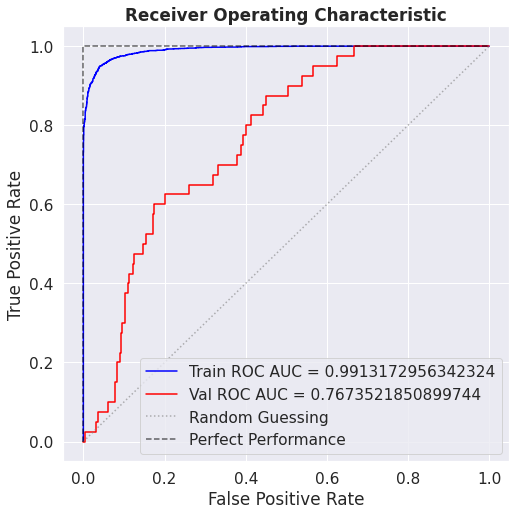

In [59]:
# obtain prediction probabilities for trg and val
y_val_probs = gb_clf.predict_proba(X_val)
y_trg_probs = gb_clf.predict_proba(X_train_os)

# plot our ROC curve
plot_roc_curve(y_train_os, y_trg_probs, y_val, y_val_probs)

Not too shabby, but we could certainly improve this further before settling on a final model.

Lets also see how our precision recall curve looks using these predictions on the validation set:

In [60]:
def plot_prec_rec_curve(y_train, y_train_probs, y_val, y_val_probs, figsize=(14,6)):
    """ Helper function to plot the ROC AUC from given labels """
    # obtain true positive and false positive rates for roc_auc
    prec, rec, thresholds = precision_recall_curve(y_train, 
                                                   y_train_probs[:, 1], 
                                                   pos_label=1)
    prec_rec_auc = auc(rec, prec)

    # obtain true positive and false positive rates for roc_auc
    val_prec, val_rec, val_thresholds = precision_recall_curve(y_val, 
                                                               y_val_probs[:, 1], 
                                                               pos_label=1)
    val_prec_rec_auc = auc(val_rec, val_prec)

    plt.figure(figsize=figsize)
    plt.plot(prec, rec, 
             label=f"Train Precision-Recall AUC = {prec_rec_auc}", color='blue')
    plt.plot(val_prec, val_rec, 
             label=f"Val Precision-Recall AUC = {val_prec_rec_auc}", color='red')
    plt.plot([0,1], [0, 1], label="Random Guessing", 
             linestyle=":", color='grey', alpha=0.6)
    plt.plot([0, 0, 1], [0, 1, 1], label="Perfect Performance", 
             linestyle="--", color='black', alpha=0.6)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve", weight='bold')
    plt.legend(loc='best')
    plt.show()

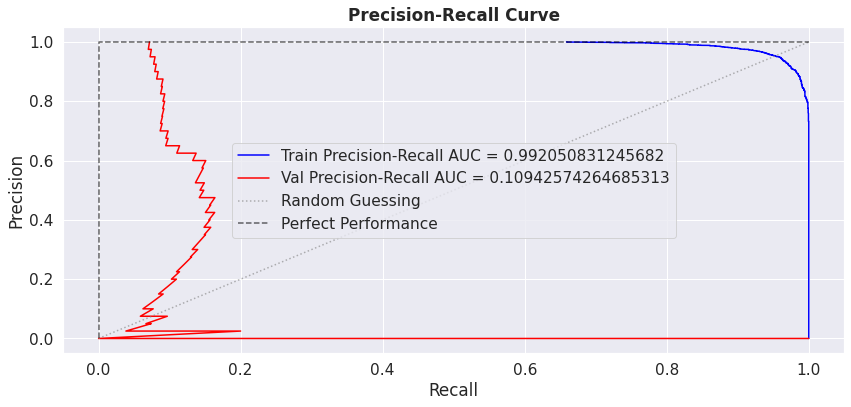

In [61]:
# plot our precision recall curve
plot_prec_rec_curve(y_train_os, y_trg_probs, y_val, y_val_probs)

All things considered, the model performs terribly in terms of recall. Even through adjustment of thresholds, there is no easy way to increase its performance in reducing false negatives. We can only achieve a high recall by completely diminishing precision, which is not ideal and eliminates any intelligence from our model.

It seems to improve this we need to significantly tune the model, or choose a more appropriate model for this problem.

<a id="test-predictions"></a>
## 6. Predictions on the test sets 

In [62]:
test_preds = gb_clf.predict(X_test)

In [63]:
print(classification_report(test_preds, y_test))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       921
           1       0.34      0.17      0.23       101

    accuracy                           0.89      1022
   macro avg       0.63      0.57      0.58      1022
weighted avg       0.86      0.89      0.87      1022



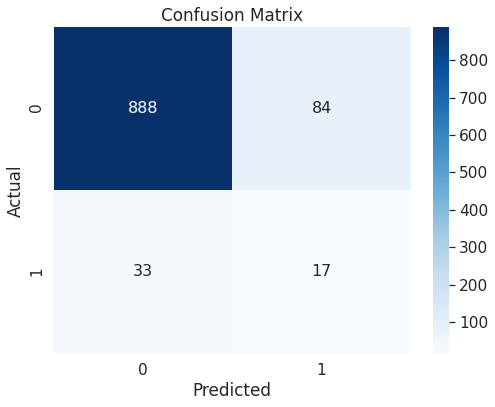

In [64]:
plot_confusion_matrix(y_test, test_preds)

Overall, our model is still poor in terms of recall, which we could improve further through modification of our thresholds for predictions. Since we would much rather spot someone who might have a stroke (minimise false negatives) rather than trying to avoid inadvertently classifying a healthy person as a risk of stroke (minimising false positives), we should prioritise our recall, rather than precision.

We can do this type of analysis better through the use of precision-recall curves and Reciever Operator Characteristic Area Under the Curve (ROC-AUC).

In [65]:
# obtain prediction probabilities for trg and val
y_test_probs = gb_clf.predict_proba(X_test)

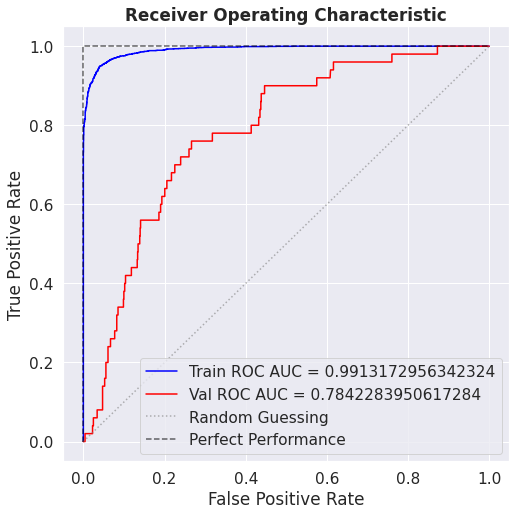

In [66]:
plot_roc_curve(y_train_os, y_trg_probs, y_test, y_test_probs)

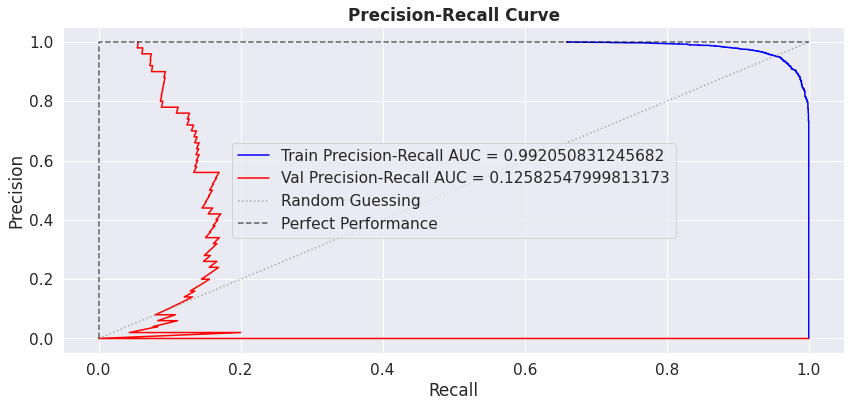

In [67]:
plot_prec_rec_curve(y_train_os, y_trg_probs, y_test, y_test_probs)

Well, not too shabby... but then again, definitely room for improvement. There are a huge range of additional techniques we can apply to improve this performance for imbalanced binary classification, but we'll leave these for another time.

Many thanks for reading through this notebook! I hope you enjoyed and found some use from it!